## Import the needed Libraries

In [1]:
import numpy as np
from scipy.io import wavfile
import scipy.io
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import  os
import math
import random

## a) Computing Spectrograms of the audio files

#### Observations from analysis of audio files

- All the music files had a sampling frequency of 16K samples per second
- The total number of samples in each audio file was common for all (480000 samples)

Number of samples in 1s = 16K 

Number of samples in 25ms = $16K * 0.025$ = $400$ samples

The shift between successive windows  = $10ms$

Number of samples to shift moving from one window to next = $16K * 0.010$ = 160 samples


#### Number of windows  

Without adding any amounts of padding at the end so the left end of the window should move only upto $480000-400 = 479600$

We will be shifting by 160 samples each time.

The total number of windows/frames = $\frac{479600}{160} = 2997.5 = (approx) 2998$

In [2]:
class Spectrogram:    
    def __init__(self,folder_path=None,test = False):
        self.name=folder_path
        self.num_frames = None
        self.test = test
        self.points = []
        self.labels = []
       
    #Plot the time series graph of the waveform
    def plot_time_series_graph(self,wav_file):
        time = np.linspace(0,length,wav_file.shape[0])
        plt.plot(time, wav_file, label="channel")
        plt.xlabel("time (s)")
        plt.ylabel("Amplitude")
        plt.show()
    
    # Computing the number of frames in the spectrogram
    def compute_num_frames(self,audiofile):
        starting=0
        increment = 160
        window_size = 400
        self.num_frames = 0
        while(starting+window_size <= len(audiofile)):
            self.num_frames+=1
            starting += increment 
    
    # Compute the spectrogram from the data 
    def compute_spectrogram(self,audiofile):
        
        starting = 0
        increment = 160
        window_size = 400
        
        if(self.num_frames is None):
            self.compute_num_frames(audiofile)
        spectrogram = None
        while(starting+window_size < len(audiofile)):
            current_window = np.array(audiofile[starting : starting + window_size])
            #Perform the required transformation
            fft_transform = np.log(np.abs(np.fft.fft(current_window,n=64)[:32].reshape(32,1))+1e-10)
            if spectrogram is None:
                spectrogram = fft_transform
            else:
                spectrogram = np.append(spectrogram,fft_transform,axis = 0)
            starting += increment
        return spectrogram
    
    # Preparing the Data Matrix for training the size of dataset would be 32 * (Total frames taken from all audio)
    def compute_feature_matrix(self):
        
        for file in os.listdir(self.name):
            #print(file)
            if self.test:
                file_class = file.split("_")[0]
                if(file_class=='music'):
                    self.labels.append(0)
                else:
                    self.labels.append(1)
                
        
            sample_rate, wav_file = wavfile.read(self.name+"/"+file)
            spectrogram = self.compute_spectrogram(wav_file).reshape((32,-1))
            self.points.append(spectrogram)
        #print(self.labels)   
        #self.plot_spectrogram(spectrogram)
        #print(self.original_data_matrix.shape)
        
    # Function to plot the spectrogram    
    def plot_spectrogram(self,spectrogram):
        time = np.linspace(0,self.num_frames,num=self.num_frames)
        freq = np.linspace(0,32,32)
        plt.pcolormesh(time,freq,spectrogram)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.show()

## Loading the training music and speech files along with test music files for discretization

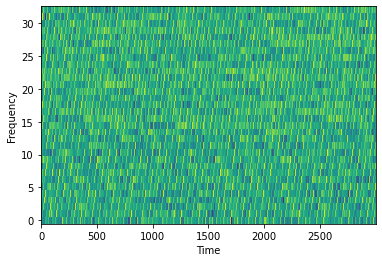

In [3]:
music_data = Spectrogram('speech_music_classification/train/music')
music_data.compute_feature_matrix()
music_data.plot_spectrogram(music_data.points[0])

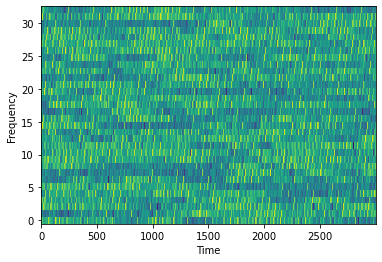

In [4]:
speech_data = Spectrogram('speech_music_classification/train/speech')
speech_data.compute_feature_matrix()
speech_data.plot_spectrogram(speech_data.points[0])

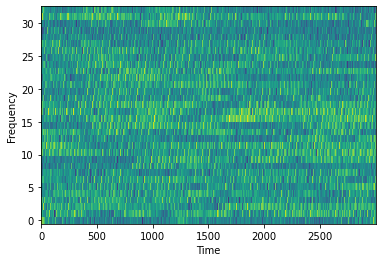

In [5]:
test_data = Spectrogram('speech_music_classification/test/',test=True)
test_data.compute_feature_matrix()
test_data.plot_spectrogram(test_data.points[0])

## b) KMeans Clustering

- A spectrogram is taken as one observation sequence
- The frames within a spectrogram constitute the observation
- KMeans algorithm is performed on all the frames taken from the music,speech and test audio files
- Total number of frames = 383744

In [6]:
class KMeans:
    
    def __init__(self,K,music_data_points,speech_data_points=None,test_data_points=None,max_iter = 20):
        self.K = K
        self.points=None
        self.max_iter = max_iter
        self.centers = {}
        self.covs = {}
        self.labels = {}
        self.colors = ['blue','orange','green','red','purple','brown','pink']
        self.discretized_data = None
        
        
        # Concatenate the frames from all files inorder to
        # obtain a matrix of dimension (Total Frames)*32
        
        for i in range(len(music_data_points)):
            if self.points is None:
                self.points = music_data_points[i].transpose()
            else:
                self.points = np.append(self.points,music_data_points[i].transpose(),axis=0)
        
        if speech_data_points is not None:
            for i in range(len(music_data_points)):
                self.points = np.append(self.points,speech_data_points[i].transpose(),axis=0)
        if test_data_points is not None:
            for i in range(len(test_data_points)):
                self.points = np.append(self.points,test_data_points[i].transpose(),axis=0)
        
        print(self.points.shape)
        
    
    # Utility function for obtaining the scatterplot 
    # of points
    def scatter_plot(self):
        for k in range(self.K):
            points = self.labels[k]
            for i in range(len(points)):
                plt.scatter(points[i][0],points[i][1],c=self.colors[k])
        
    
    # Given a point find the cluster to which 
    # the point belongs
    def get_cluster(self,data_point):
        return np.argmin(np.array([np.linalg.norm(data_point-self.centers[c]) for c in range(self.K)]))        
    
    
    # Kmeans Algorithm
    def run(self):
        #Initialization of the centers
        for i in range(self.K):
            self.centers[i] = self.points[i]
        
        for i in range(self.max_iter):
            
            for k in range(self.K):
                self.labels[k] = []
            
            # Reassign points to clusters
            for p in range(len(self.points)):
                current_point = self.points[p]
                label = np.argmin(np.array([np.linalg.norm(current_point-self.centers[c]) for c in range(self.K)]))
                self.labels[label].append(current_point)
            
            # Find the new cluster after 
            # reInitialization of cluster centers
            new_centers = {}
            for k in range(self.K):
                mean_vector = np.mean(np.array(self.labels[k]),axis=0)
                new_centers[k] = mean_vector
            self.centers = new_centers 

In [7]:
# Run the KMeans Algorithm dividing the points into 8 classes 
k = KMeans(8,music_data.points,speech_data.points,test_data.points)
k.run()

(383744, 32)


In [8]:
def discretize_data(kmeans,data):
    ans = []
    for file in data:
        points = []
        current_file = file.transpose()
        for i in range(current_file.shape[0]):
            points.append(kmeans.get_cluster(current_file[i]))
        ans.append(points)
    return ans

### Discretize points according to the cluster into which the frame belongs

In [9]:
music = discretize_data(k,music_data.points)
speech = discretize_data(k,speech_data.points)
test = discretize_data(k,test_data.points)

## c) HMM

### Used scaling approach by normalizing probabilities

#### Reference : https://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf


**Forward Variable**
### $\tilde{\alpha_t}(i) = \sum_{N-1}^{j=0}\hat{\alpha_{t-1}(j)}a_{ji}b_{i}(O_{t})$

Taking 
### $c_{t} = \frac{1}{\sum_{j=0}^{N-1}\tilde{\alpha }(j)}$

We can scale the forward estimate by $c_t$

### $\hat{\alpha_t(i)} = c_t \tilde{\alpha_t}(i)$

Using the scaling factor $c_t$. The probability of an observation given an HMM Model


### $P(O|\lambda) = \frac{1}{\prod_{j=0}^{T-1}c_j}$

To avoid underflow we compute $log(P(O|\lambda))$

### $log(P(O|\lambda)) = -\sum_{j=0}^{T-1} log(c_j)$

The same scaling factor can be used while computing the backward variable beta leading to the same 
likelihood equation as that of the forward variable

By using the scaled $\alpha$ and $\beta$ we can compute $\gamma$ and $\epsilon$ needed for performing 
the EM algorithm iteration step

### $\gamma_t(i) = P(s_t = i | \lambda) = \frac{\alpha_t(i)*\beta_t(i)}{\sum_{x=0}^{N}(\alpha_t(x)*\beta_t(x))}$

### $\epsilon_t(i,j) = P(s_t = i , S_{t+1} = j | \lambda)  = \frac{\alpha_t(i)*a_{ij}*b_j(O_{t+1})*\beta_{t+1}(j)}{\sum_{y,z}\alpha_t(y)*a_{yz}*b_z(O_{t+1})*\beta_{t+1}(z)}$

Using this the EM Algorithm step can be wriiten as

###  $\pi(i) = \gamma_{1}(i)$

### $a_{ij} = \frac{\sum_{t=1}^{T}(\epsilon_{t}(i,j))}{\sum_{t=1}^{T}(\gamma_{t}(i))}$

### $b_{i}(O) = \frac{\sum_{t=1}^{T}1_{O_t=O}*\gamma_t(i)}{\sum_{t=1}^{T}(\gamma_{t}(i))}$

### Viterbi Algorithm

### $\delta_{t+1}(j) = max(\delta_{t}(i)*a_{ij}*b_{j}(O_{t+1}))$

### $\psi_{t+1}(j) = argmax_{i}(\delta_{t}(i)*a_{ij})$

Initial conditions
### $\delta_{1}(i) = \pi(i)*b_{1}(i)$
### $psi_{1}(i) = -1$

After reaching the final observation we compute
### $q_{T} = argmax(\delta_T(i))$
we trace the backpointers using $\psi$ until we hit -1 after which we return the sequence after reversing the order


In [10]:
# Helper functions for taking logarithm of probabilities while working in the log space
# Used in Viterbi Algorithm
# Reference : http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf

# Handling Undefined case for log(0)
LOGZERO = float('-inf')

# Returns logarithm of a number else LOGZERO if undefined
def eln(x):
    if x==0:
        return LOGZERO
    if x>0:
        return math.log(x)
    return LOGZERO

# Returns the e^x
def eexp(x):
    if x==LOGZERO:
        return 0
    else:
        return math.exp(x)


# Returns the logarithm of sum of two numbers
# given the logarithm of both numbers as input
def elnsum(eln_x,eln_y):
    if eln_x==LOGZERO or eln_y==LOGZERO:
        if (eln_x==LOGZERO):
            return eln_y
        else:
            return eln_x
    if(eln_x > eln_y):
        return eln_x + eln(1+math.exp(eln_y-eln_x))
    return eln_y + eln(1+math.exp(eln_x-eln_y))


# Returns the logarithm of product of two numbers
# given the logarithm of both numbers as input
def elnproduct(eln_x,eln_y):
    if eln_x==LOGZERO or eln_y==LOGZERO:
        return LOGZERO
    return eln_x + eln_y
    


In [11]:
class HMM:
    
    def __init__(self):
        
        # Initial Parameters of the HMM (pi,A,B)
        self.init_pi = np.array([0.5,0.5,0.0])
        self.init_A = np.array([ [0.6,0.4,0] , [0.3,0.5,0.2],[0.0,0.1,0.9] ])
        self.init_b = np.array([
                            [0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.0],
                            [0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],
                            [0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0]
                      ])
        
        self.pi = np.array([0.5,0.5,0.0])
        self.A = np.array([ [0.6,0.4,0] , [0.3,0.5,0.2],[0.0,0.1,0.9] ])
        self.b = np.array([
                            [0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.0],
                            [0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],
                            [0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0]
    
                      ])
        self.max_iter = 15
    
    
    # Computing the log likelihood using the scaling factors
    # and using it as a measure of likelihood
    def compute_likelihood(self,data_point):
        alpha,scaling_factor = self.forward(data_point)
        likelihood =0
        for scale in scaling_factor:
            likelihood = likelihood + np.log(scale)
        likelihood = -likelihood
        return likelihood
        
    # Forward Estimation given the observation    
    def forward(self,data_point):
        scaling_factors = []
    
        alpha = np.zeros((len(data_point),len(self.pi)))
        for i in range(len(self.pi)):
            alpha[0][i] = self.pi[i]*self.b[i,data_point[0]]
        

        c = 1.0/(np.sum(alpha[0]))
        scaling_factors.append(c)
        
        # Multiply the scaling factor to all element in alpha_0
        for i in range(len(self.pi)):
            alpha[0][i] = (c)*alpha[0][i]
        
        # Forward Update Equation
        for i in range(1,len(data_point)):
            for j in range(len(self.pi)):
                alpha[i][j] = 0
                
                for k in range(len(self.pi)):
                    alpha[i][j] = alpha[i][j] + alpha[i-1][k]*self.A[k][j]
                alpha[i][j] = alpha[i][j] * self.b[j][data_point[i]]
            
            # Compute the scaling factor corresponding to alpha_t
            c = (1.0/np.sum(alpha[i]))
            scaling_factors.append(c)

            for j in range(len(self.pi)):
                alpha[i][j] = (c)*alpha[i][j]
        
        # Return the forward estimate with scaling factor for use in backward estimation
        return (alpha,scaling_factors)

    
    
    # Estimation using the backward variable given the scaling factors
    # obtained from the forward algorithm
    # Reference : https://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf
    def backward(self,data_point,scaling_factor):
        
        beta = np.zeros((len(data_point),len(self.init_pi)))
        for i in range(len(self.init_pi)):
            beta[len(data_point)-1][i] = scaling_factor[len(data_point)-1]
        
        for t in range(len(data_point)-2,-1,-1):
            for i in range(len(self.init_pi)):
                beta[t][i] = 0
                for j in range(len(self.init_pi)):
                    beta[t][i] = beta[t][i] + self.A[i][j]*self.b[j][data_point[t+1]]*beta[t+1][j]
                beta[t][i] = beta[t][i]*scaling_factor[t]
        return beta
    
    
    # Implementation of the Viterbi Algorithm
    def viterbi(self,data_point):
      
        delta = np.zeros((len(data_point), len(self.init_pi)))
        
        # Estimate for delta[0]
        for i in range(len(self.pi)):
            delta[0][i] = elnproduct(eln(self.pi[i]),eln(self.b[i][data_point[0]]))
           
        # list for storing the previous pointers
        psi = np.zeros((len(data_point)-1, len(self.init_pi)))
         
        
        for t in range(1, len(data_point)):
            for j in range(len(self.init_pi)):
                probabilities = np.zeros(len(self.pi))
                for k in range(len(self.init_pi)):
                    probabilities[k] = elnproduct(delta[t - 1][k] , elnproduct(eln(self.A[k][j]), eln(self.b[j][data_point[t]])))
                psi[t - 1][j] = np.argmax(probabilities)
                delta[t][j] = np.max(probabilities)
 

        path = []
        last_state = np.argmax(delta[len(data_point) - 1, :])
        path.append(last_state)
 

        backtrack_index = 1
        for i in range(len(data_point)- 2, -1, -1):
            path.append(int(psi[i][ int(last_state)]))
            last_state = psi[i][int(last_state)]
            backtrack_index += 1
 
     
        path.reverse()
        return path
    
    
    # Compute the gamma and epsilon matrices given alpha, beta and the datapoints
    def compute_gamma_epsilon(self,alpha,beta,data_point):
        
        gamma = np.zeros((alpha.shape[0],alpha.shape[1]))
        epsilon = np.zeros((alpha.shape[0],alpha.shape[1],alpha.shape[1]))
        
        for t in range(alpha.shape[0]-1):
            for i in range(alpha.shape[1]):
                gamma[t][i] = 0
                for j in range(alpha.shape[1]):
                    epsilon[t][i][j] = alpha[t][i]*self.A[i][j]*self.b[j][data_point[t+1]]*beta[t+1][j]
                    gamma[t][i] += epsilon[t][i][j]
        
        
        for t in range(alpha.shape[1]):
            gamma[alpha.shape[0]-1][t] = alpha[alpha.shape[0]-1][i]
        
        return (gamma,epsilon)
   
    
    def baum_welch(self,data_points):
        
        likelihoods = []
        for e in range(self.max_iter):
            
            # Store the estimates over all the data points and average it out
            pi_estimate = np.zeros(len(self.pi))
            a_estimate = np.zeros((len(self.pi),len(self.pi)))
            b_estimate = np.zeros((len(self.pi),self.b.shape[1]))
            
            a_denominator = np.zeros((len(self.pi),len(self.pi)))
            b_denominator = np.zeros((len(self.pi),self.b.shape[1]))
            likelihood = 0
            
            for data_point in data_points:
                # Compute alpha and beta
                alpha,scaling_factor = self.forward(data_point)
                beta  =self.backward(data_point,scaling_factor)
                
                # Compute the likelihood of the observation P(O|lambda)
                logprob =0
                for scale in scaling_factor:
                    logprob = logprob + np.log(scale)
                logprob = -logprob
                likelihood = likelihood + logprob

            
                # Compute Gamma and epsilon
                gamma,epsilon = self.compute_gamma_epsilon(alpha,beta,data_point)
                
                
                # Find the estimate for pi
                for i in range(len(self.pi)):
                    pi_estimate[i] += gamma[0][i]
                
                
                # Find the estimate of aij for all i,j
                for i  in range(len(self.pi)):
                    denominator = 0
                    for t in range(len(data_point)-1):
                        denominator =denominator + gamma[t][i]
                    
                    for j in range(len(self.pi)):
                        numerator =0
                        for t in range(len(data_point)-1):
                            numerator = numerator + epsilon[t,i,j]
                        a_estimate[i][j] += numerator
                        a_denominator[i][j] += denominator

                # Find the estimate of b
                for i in range(len(self.pi)):
                    denominator = 0
                    for t in range(len(data_point)):
                        denominator =denominator + gamma[t][i]
                    for j in range(self.b.shape[1]):
                        numerator = 0
                        for t in range(len(data_point)):
                            if(data_point[t] == j):
                                numerator = numerator + gamma[t][i]
                        b_estimate[i][j] += numerator
                        b_denominator[i][j] += denominator
            
            
            # Restimate pi,A,b
            pi_estimate = pi_estimate*(1.0/len(data_points))

            for i in range(len(self.pi)):
                for j in range(len(self.pi)):
                    a_estimate[i][j] = a_estimate[i][j] / a_denominator[i][j]
            
            for i in range(len(self.pi)):
                for j in range(self.b.shape[1]):
                    b_estimate[i][j] = b_estimate[i][j] / b_denominator[i][j]
            
            # Assign the newly created estimate for the next iteration
            self.pi = pi_estimate
            self.A = a_estimate
            print(self.A)
            self.b = b_estimate
            print("Epoch " + str(e)+" Likelihood ==  " + str(likelihood))
            likelihoods.append(likelihood)
        
        plt.xlabel("Iterations count")
        plt.ylabel("Log Likelihood")
        for i in range(len(likelihoods)):
            plt.scatter(i+1,likelihoods[i],c='r')
        plt.show()

### c)a) and c)b) 

Since the forward and backward variables are computed using the scaling factor and the same scaling factor used while computing $\alpha$ is used while computing the backward variable $\beta$. The results of both forward and backward estimation are same

### $P(O|\lambda) = \frac{1}{\prod_{j=0}^{T-1}c_j}$

To avoid underflow we compute $log(P(O|\lambda))$

### $log(P(O|\lambda)) = -\sum_{j=0}^{T-1} log(c_j)$


In [12]:
sample_speech_file = speech[random.randint(0,len(speech))]
sample_music_file = music[random.randint(0,len(music))]

In [13]:
hmm = HMM()
speech_likelihood = hmm.compute_likelihood(sample_speech_file)
music_likelihood = hmm.compute_likelihood(sample_music_file)

print("Log Likelihood of audio file being speech = " + str(speech_likelihood))
print("Log Likelihood of audio file being music = " + str(music_likelihood))


Log Likelihood of audio file being speech = -5820.379209131901
Log Likelihood of audio file being music = -5892.971773910469


**Comparing the log likelihoods it seems that the HMM is more likely for Speech Data** but random runs gave more likelihood to music file on fewer instances

### c)c)  Get the best state sequence corresponding to the given observation sequence


In [14]:
print("Best State Sequence corresponding to the given observation sequence (Speech File)(First 40 states)")
print(hmm.viterbi(sample_speech_file)[:40])
print("Best State Sequence corresponding to the given observation sequence (Music File) (First 40 states)")
print(hmm.viterbi(sample_music_file)[:40])

Best State Sequence corresponding to the given observation sequence (Speech File)(First 40 states)
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Best State Sequence corresponding to the given observation sequence (Music File) (First 40 states)
[0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]


### c)d) Training the HMM Model

[[0.74083124 0.25916876 0.        ]
 [0.20267729 0.69795247 0.09937023]
 [0.         0.22557292 0.77442708]]
Epoch 0 Likelihood ==  -237393.85738952065
[[0.87433479 0.12566521 0.        ]
 [0.12772529 0.75457287 0.11770185]
 [0.         0.22571988 0.77428012]]
Epoch 1 Likelihood ==  -190406.89865803445
[[0.91197767 0.08802233 0.        ]
 [0.09766322 0.77959171 0.12274507]
 [0.         0.22889444 0.77110556]]
Epoch 2 Likelihood ==  -183143.5551063749
[[0.91810062 0.08189938 0.        ]
 [0.09239792 0.78743543 0.12016665]
 [0.         0.23036771 0.76963229]]
Epoch 3 Likelihood ==  -181758.26312199593
[[0.91914083 0.08085917 0.        ]
 [0.09132675 0.79272382 0.11594943]
 [0.         0.23083418 0.76916582]]
Epoch 4 Likelihood ==  -181426.24257158933
[[0.91927598 0.08072402 0.        ]
 [0.09039889 0.79870861 0.1108925 ]
 [0.         0.23119165 0.76880835]]
Epoch 5 Likelihood ==  -181141.57864802418
[[0.91897826 0.08102174 0.        ]
 [0.08882531 0.80701748 0.10415722]
 [0.         0.23

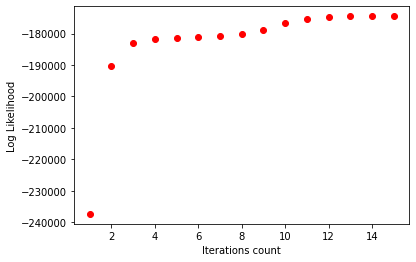

In [15]:
speech_hmm = HMM()
speech_hmm.baum_welch(speech)

Epoch 0 Likelihood ==  -237047.1678378759
Epoch 1 Likelihood ==  -200353.15563926334
Epoch 2 Likelihood ==  -191190.6525754919
Epoch 3 Likelihood ==  -189660.50284950918
Epoch 4 Likelihood ==  -189161.72348008316
Epoch 5 Likelihood ==  -188751.85310853441
Epoch 6 Likelihood ==  -188337.3517279937
Epoch 7 Likelihood ==  -187820.04903146782
Epoch 8 Likelihood ==  -187033.61902952523
Epoch 9 Likelihood ==  -185607.91911836836
Epoch 10 Likelihood ==  -183422.976816524
Epoch 11 Likelihood ==  -182205.59400622678
Epoch 12 Likelihood ==  -181913.96672403303
Epoch 13 Likelihood ==  -181823.69267425424
Epoch 14 Likelihood ==  -181789.03453686784


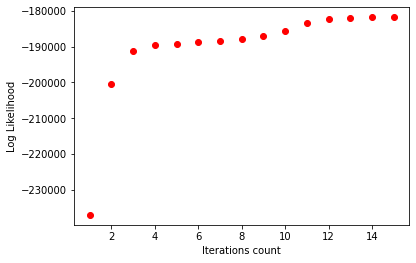

In [16]:
music_hmm = HMM()
music_hmm.baum_welch(music)

## Performance of the HMM Model

In [17]:
# Class Labels were 0 for audio files belonging to the music class
# while it is 1 for audio files belonging to the speech class

def test_accuracy(dataset,hmm_music,hmm_speech,labels):
    accuracy = 0
    for i in range(len(dataset)):
        data_point = dataset[i]
        music_likelihood = hmm_music.compute_likelihood(data_point)
        speech_likelihood = hmm_speech.compute_likelihood(data_point)
        
        predicted_class =  0 if music_likelihood>=speech_likelihood else 1
        if(labels[i]==predicted_class):
            accuracy+=1
            
    ans = ((1.0*accuracy) / len(dataset))*100
    print("Accuracy of the HMM Model = " + str(ans))

test_accuracy(test,music_hmm,speech_hmm,test_data.labels)


Accuracy of the HMM Model = 68.75


The HMM Model gave an accuracy of = 68.75%